# STOCK MARKET ANOMALY DETECTION USING PYTHON

In [17]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
sns.set(style="whitegrid")

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA','NVDA']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-06-20   AAPL  184.282242  185.009995  186.100006  184.410004   
1         2023-06-20   GOOG  123.709221  123.849998  125.175003  122.830002   
2         2023-06-20   MSFT  335.426086  338.049988  342.079987  335.859985   
3         2023-06-20   NFLX  434.700012  434.700012  440.000000  430.000000   
4         2023-06-20   NVDA   43.794884   43.807999   43.990002   42.674000   

Attribute        Open       Volume  
0          184.410004   49799100.0  
1          123.535004   22698000.0  
2          339.309998   26375400.0  
3          430.179993    4756000.0  
4           42.998001  451153000.0  


In [18]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())


Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-06-20   AAPL  184.282242  185.009995  186.100006  184.410004  184.410004   
2023-06-20   GOOG  123.709221  123.849998  125.175003  122.830002  123.535004   
2023-06-20   MSFT  335.426086  338.049988  342.079987  335.859985  339.309998   
2023-06-20   NFLX  434.700012  434.700012  440.000000  430.000000  430.179993   
2023-06-20   NVDA   43.794884   43.807999   43.990002   42.674000   42.998001   

Attribute        Volume  
Date                     
2023-06-20   49799100.0  
2023-06-20   22698000.0  
2023-06-20   26375400.0  
2023-06-20    4756000.0  
2023-06-20  451153000.0  


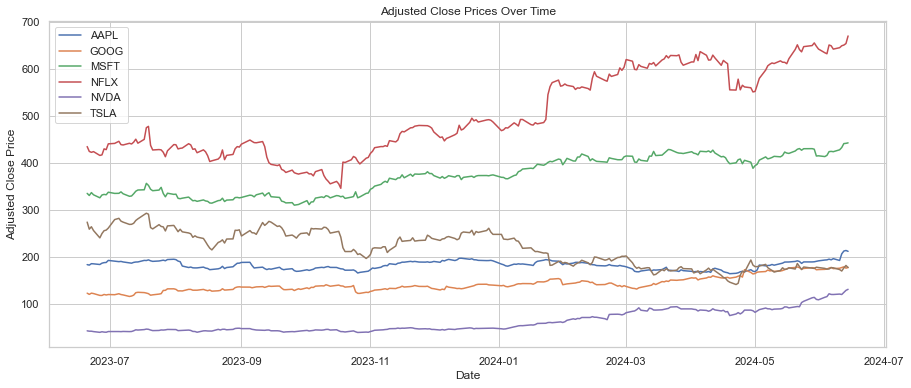

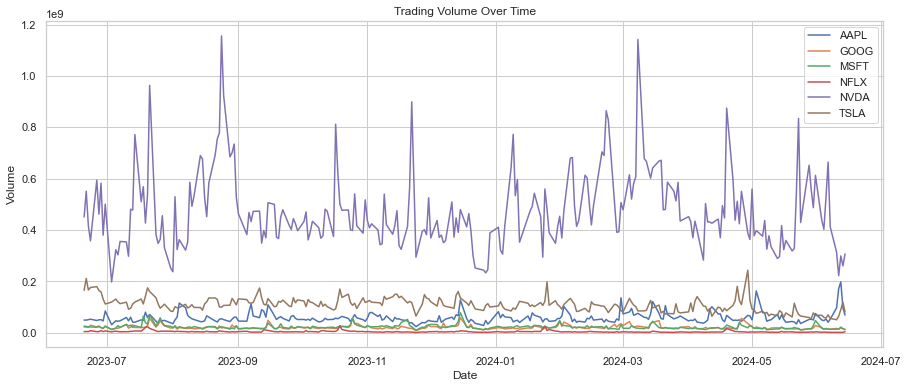

In [19]:


# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

**Detecting Anomalies in the Stock Market**

Given the variability and trends observed in both adjusted close prices and trading volumes, anomaly detection can focus on identifying:

Significant price movements that deviate from the stock’s typical price range or trend.
Unusual trading volumes that stand out from the normal trading activity.
For the task of stock market anomaly detection, we can use the Z-score method, which identifies anomalies based on how many standard deviations away a data point is from the mean. A common threshold for identifying an anomaly is a Z-score greater than 2 or less than -2, which corresponds to data points that are more than 2 standard deviations away from the mean.

We will compute the Z-scores for both the adjusted close prices and trading volumes for each stock and then identify any data points that exceed this threshold:

In [20]:
def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-06-11   AAPL  207.149994  207.149994  207.160004  193.630005  193.649994   
2024-06-12   AAPL  213.070007  213.070007  220.199997  206.899994  207.369995   
2024-06-13   AAPL  214.240005  214.240005  216.750000  211.600006  214.740005   
2024-06-14   AAPL  212.490005  212.490005  215.169998  211.300003  213.850006   
2024-05-16   GOOG  175.230591  175.429993  176.339996  174.050003  174.600006   

Attribute        Volume   Z-score  
Date                               
2024-06-11  172373300.0  2.580953  
2024-06-12  198134300.0  3.212546  
2024-06-13   97862700.0  3.337370  
2024-06-14   69175600.0  3.150667  
2024-05-16   17247300.0  2.065233  


In [21]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-08-04   AAPL  181.274155  181.990005  187.380005  181.919998  185.520004   
2023-09-07   AAPL  177.100403  177.559998  178.210007  173.539993  175.179993   
2023-09-15   AAPL  174.556976  175.009995  176.500000  173.820007  176.479996   
2023-12-15   AAPL  197.318222  197.570007  198.399994  197.000000  197.529999   
2024-02-02   AAPL  185.613159  185.850006  187.330002  179.250000  179.860001   

Attribute        Volume   Z-score  
Date                               
2023-08-04  115799700.0  2.630457  
2023-09-07  112488800.0  2.477438  
2023-09-15  109205100.0  2.325677  
2023-12-15  128256700.0  3.206177  
2024-02-02  102518000.0  2.016622  


**Plotting the adjusted close prices and trading volumes again for each company, highlighting the anomalies we detected:**

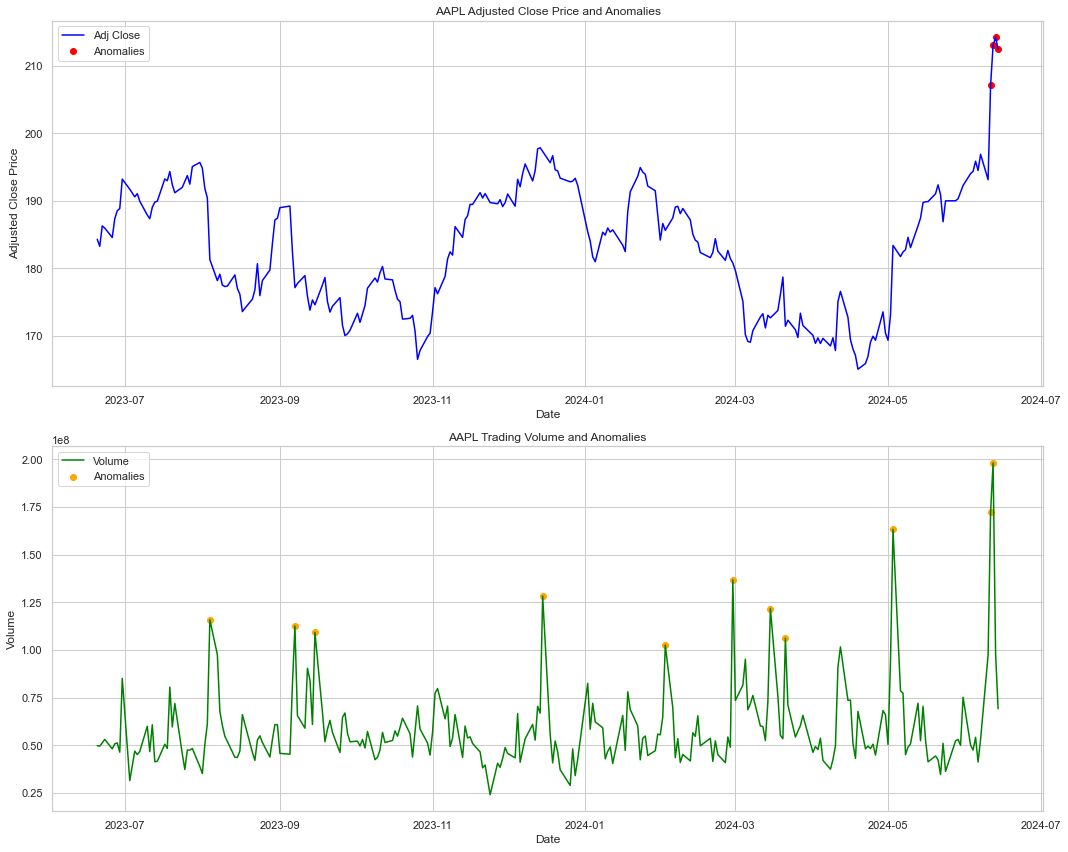

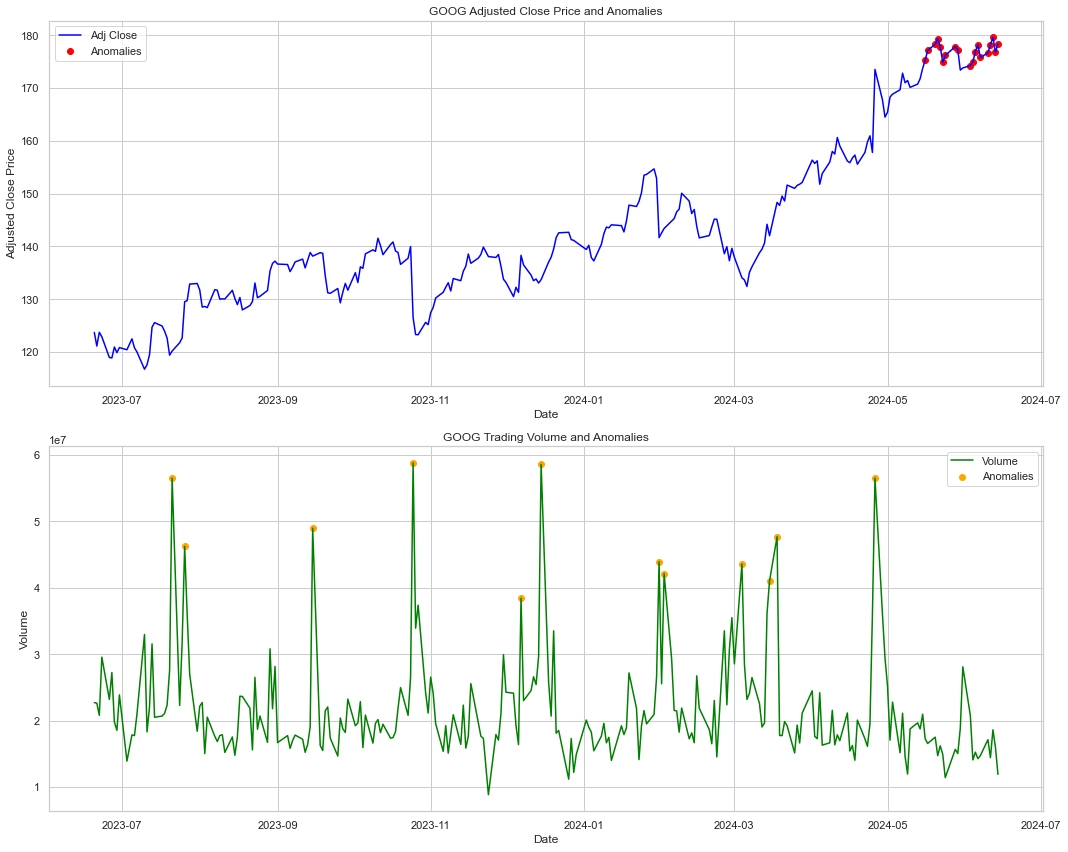

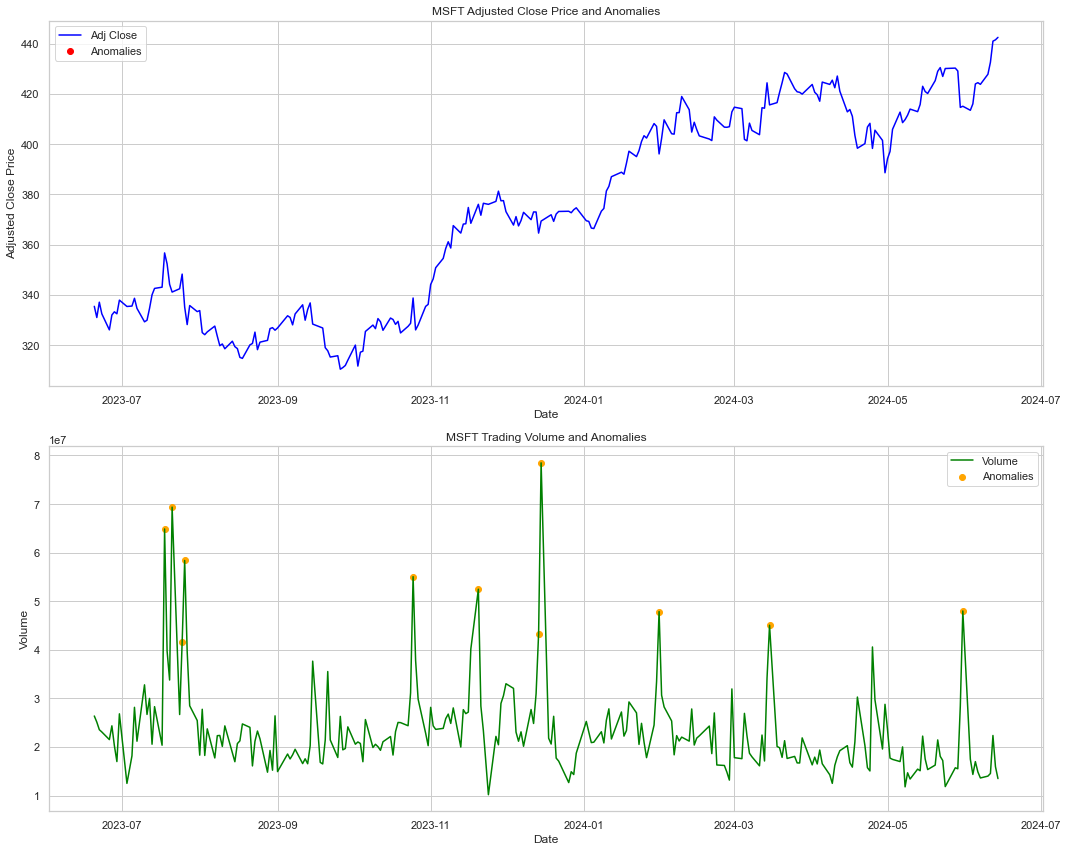

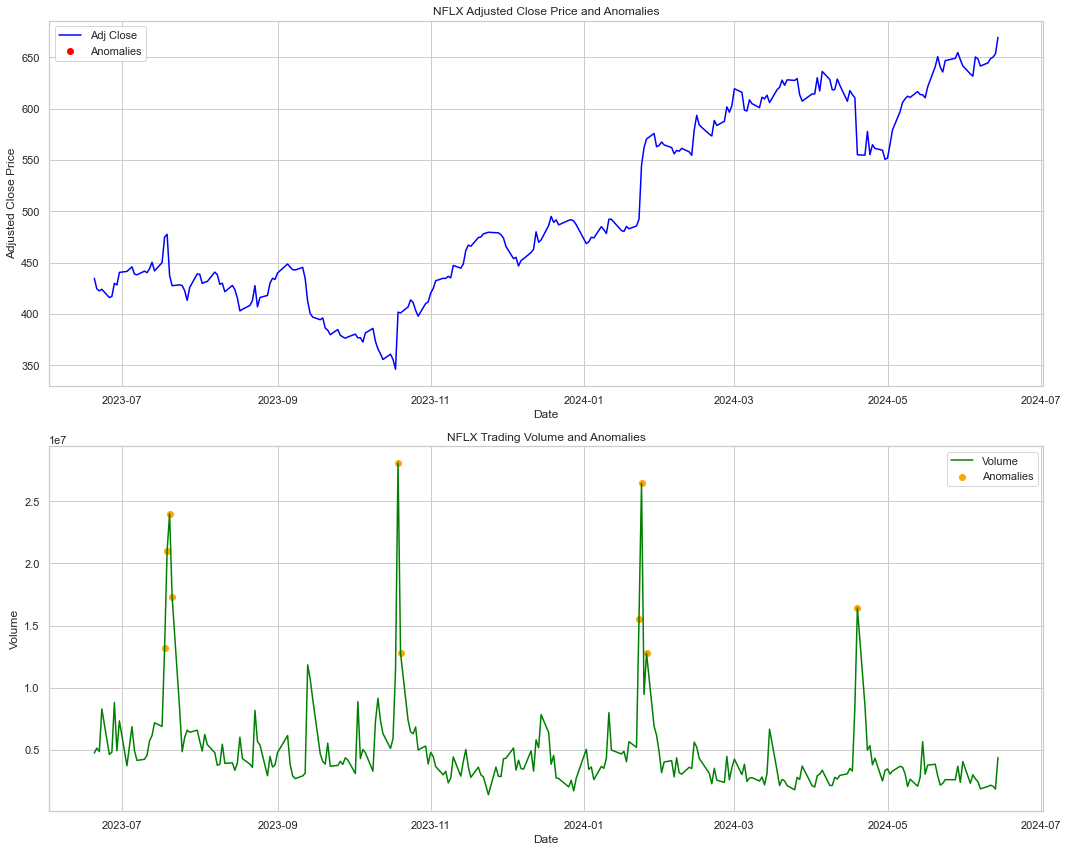

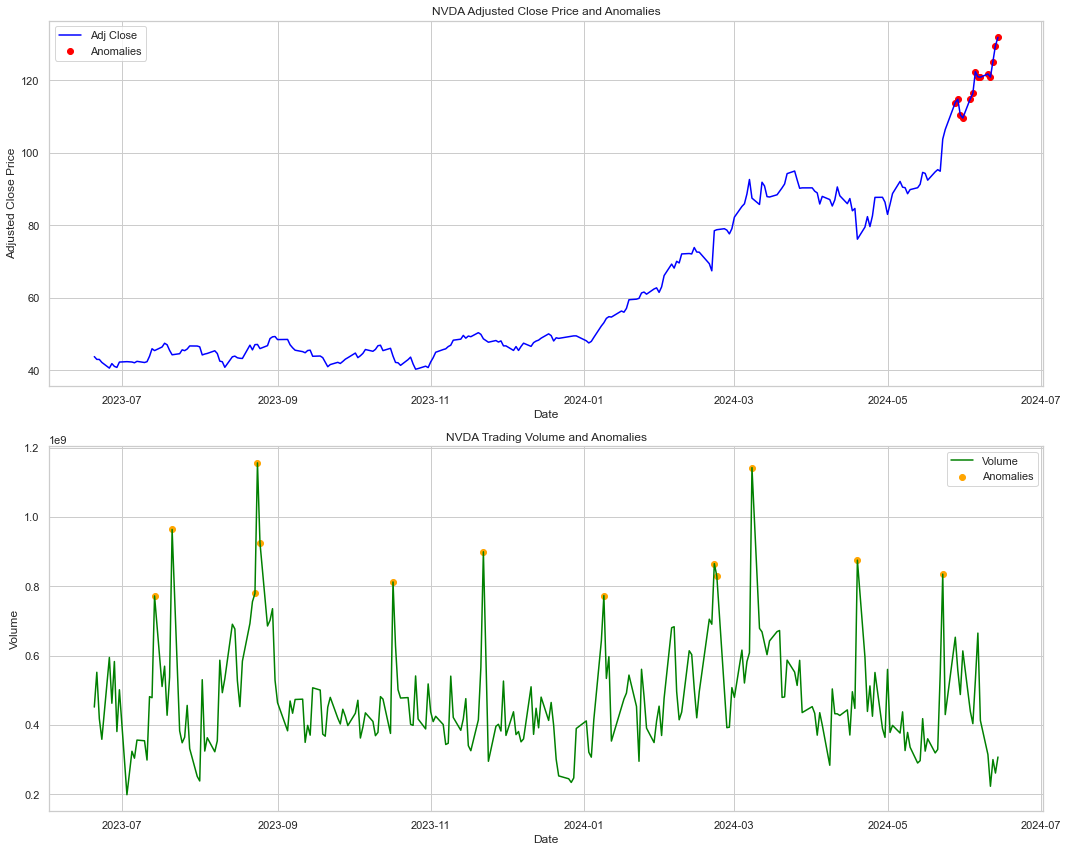

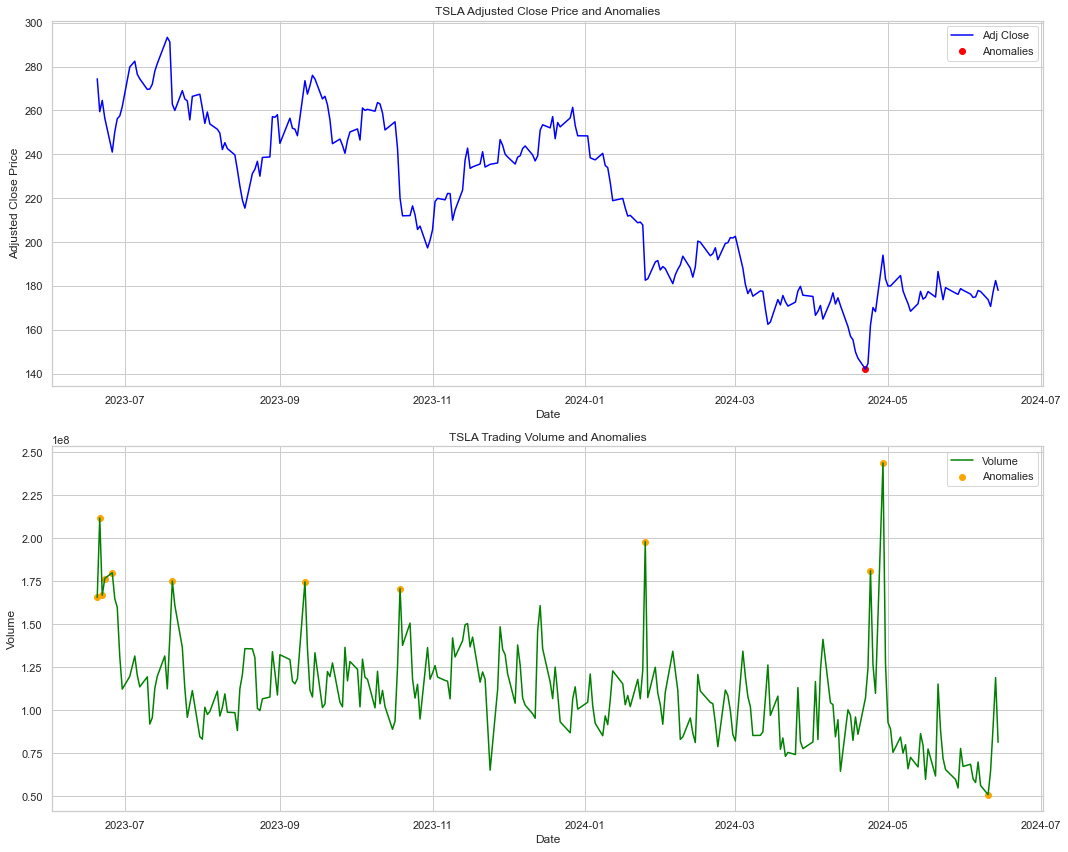

In [22]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

The above charts for each company display the adjusted close prices and trading volumes over time, with anomalies highlighted:

Anomalies are marked in red and represent significant deviations from the typical price range. These could correspond to days with unexpected news, earnings reports, or market shifts.
Anomalies in trading volume are marked in orange and indicate days with exceptionally high or low trading activity compared to the norm. Such spikes could be due to market events, announcements, or other factors influencing trader behaviour.
Now, let’s analyze the correlation in the anomalies of all the companies:

In [23]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly                                \
Ticker                                AAPL      GOOG      NVDA      TSLA   
                  Ticker                                                   
Adj Close Anomaly AAPL            1.000000  0.187317  0.356348 -0.102869   
                  GOOG            0.187317  1.000000 -0.025031 -0.549170   
                  NVDA            0.356348 -0.025031  1.000000 -0.288675   
                  TSLA           -0.102869 -0.549170 -0.288675  1.000000   
Volume Anomaly    AAPL            1.000000  0.408248  0.408248       NaN   
                  GOOG                 NaN       NaN       NaN       NaN   
                  MSFT           -0.408248 -1.000000  0.250000       NaN   
                  NFLX                 NaN       NaN       NaN       NaN   
                  NVDA           -0.408248  0.250000 -1.000000       NaN   
                  TSLA           -0.408248  0.250000  0.250000       NaN   

           

**Analyzing the Risk of Anomalies**

A stock could be considered more risky if it has frequent and large anomalies in its price or volume. Here’s how we can approach this:

Frequency of Anomalies: A higher number of anomalies may indicate a higher risk.

Magnitude of Anomalies: Larger deviations from the mean (higher absolute Z-scores) suggest higher risk.

We can compute a risk score for each stock by combining these factors.

In [24]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    1.000000
GOOG    0.443243
MSFT         NaN
NFLX         NaN
NVDA    0.295767
TSLA    0.000000
Name: Z-score, dtype: float64


### Current Risk Rating Interpretation:

**AAPL:**
Apple's risk rating is 1.00, the highest in the current assessment. This suggests that Apple's stock exhibits the most significant anomalies, indicating a relatively higher level of risk compared to other stocks analyzed.

**GOOG:**
Google's risk rating of approximately 0.44 indicates a moderate level of risk. It shows fewer or less significant anomalies compared to Apple but more than Tesla.

**MSFT:**
Microsoft's risk rating is NaN, suggesting that there were no detectable anomalies in the period analyzed, or it was not possible to calculate the risk rating for this stock due to insufficient data.

**NFLX:**
Netflix's risk rating is NaN, which, similar to Microsoft, indicates either an absence of detectable anomalies or insufficient data to determine the risk rating.

**NVDA:**
NVIDIA's risk rating of approximately 0.30 suggests a moderate level of risk, higher than Tesla but lower than Google. It indicates that NVIDIA's stock has experienced some anomalies, but they are less significant compared to those observed in Apple and Google.

**TSLA:**
Tesla has a risk rating of 0.00, indicating the lowest risk among the stocks listed. This implies that Tesla's stock exhibited the fewest and least significant anomalies during the analyzed period.